In [ ]:
!wget "https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv"

--2025-02-25 05:02:49--  https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444468 (434K) [text/plain]
Saving to: ‘sms_spam_cleaned.csv’

sms_spam_cleaned.cs 100%[===================>] 434.05K  --.-KB/s    in 0.05s   

2025-02-25 05:02:49 (9.18 MB/s) - ‘sms_spam_cleaned.csv’ saved [444468/444468]



In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
import os

# Data Clustering

In [ ]:
df = pd.read_csv("sms_spam_cleaned.csv")

In [ ]:
# Mapping spam: 1 and ham: 0
df["type"] = df["type"].map({'ham': 0, 'spam': 1})

In [ ]:
# For tokenization and vectorizer, I used CountVectorizer which implicitly handles tokenization and also does vectorization.
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(df["msg"])
y = df["type"].values

In [ ]:
# Dividing into 2 Clusters
num_clusters = 2
km = KMeans(n_clusters=num_clusters, init='random', n_init=10, verbose=1)
preds = km.fit_predict(X)
df["cluster"] = preds

Initialization complete
Iteration 0, inertia 94719.0.
Iteration 1, inertia 84296.57500530062.
Iteration 2, inertia 83653.2292214622.
Iteration 3, inertia 83342.27356064362.
Iteration 4, inertia 83222.35576731224.
Iteration 5, inertia 83176.7426855072.
Iteration 6, inertia 83136.47466038153.
Iteration 7, inertia 83119.39764344387.
Iteration 8, inertia 83109.69180530852.
Iteration 9, inertia 83100.52534847855.
Iteration 10, inertia 83093.4245618481.
Iteration 11, inertia 83088.76994008436.
Iteration 12, inertia 83084.06743608207.
Iteration 13, inertia 83076.33740238106.
Iteration 14, inertia 83072.67904335332.
Iteration 15, inertia 83069.77326318511.
Iteration 16, inertia 83067.5688201679.
Iteration 17, inertia 83065.43382823691.
Iteration 18, inertia 83063.64198924875.
Iteration 19, inertia 83062.24580749655.
Iteration 20, inertia 83060.58655572719.
Iteration 21, inertia 83059.37847587814.
Iteration 22, inertia 83058.96082560872.
Iteration 23, inertia 83058.91448751805.
Iteration 24, in

In [ ]:
cluster_labels = df.groupby('cluster')['type'].mean()
print(cluster_labels)

cluster
0    0.258570
1    0.098529
Name: type, dtype: float64


In [ ]:
spam_cluster = cluster_labels.idxmax()  # Cluster with the highest mean spam label
print(spam_cluster)

0


In [ ]:
non_spam_cluster = cluster_labels.idxmin()  # Cluster with the lowest mean spam label
print(non_spam_cluster)

1


In [ ]:
df['cluster_mapped'] = df['cluster'].map({spam_cluster: 'spam', non_spam_cluster: 'not_spam'})
print(df['cluster_mapped'].value_counts())

cluster_mapped
not_spam    4283
spam        1021
Name: count, dtype: int64


In [ ]:
df['cluster_binary'] = df['cluster_mapped'].map({'spam': 1, 'not_spam': 0})

In [ ]:
y_true = df['type']
y_pred = df['cluster_binary']

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Clustering Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}")

Clustering Accuracy: 0.78
Precision: 0.26
Recall: 0.38
F1-score: 0.31


# Clustering Quality

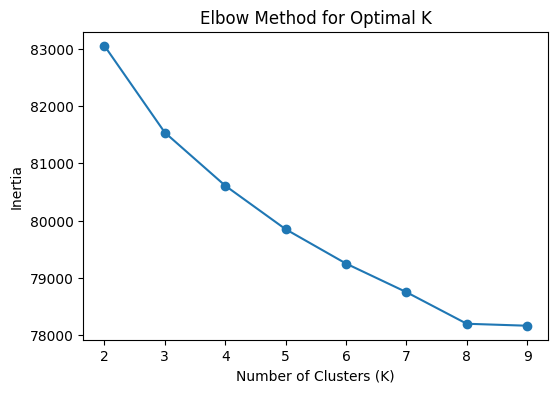

In [ ]:
# Using the Elbow Method for finding the Optimal K
inertia = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [ ]:
# Based on the graph the optimal k = 8
k_opt = 8
km_opt = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df["cluster_opt"] = km_opt.fit_predict(X)

In [ ]:
# Total Cluster Size and Spam Percentages

spam_counts = df.groupby("cluster_opt")["type"].sum()
total_counts = df["cluster_opt"].value_counts()

spam_percentage = (spam_counts / total_counts) * 100

cluster_analysis = pd.DataFrame({"Total Size": total_counts, "Spam Percentage": spam_percentage})
print(cluster_analysis)

             Total Size  Spam Percentage
cluster_opt                             
0                   927        25.566343
1                   208         6.730769
2                     1         0.000000
3                   999         6.306306
4                   296        89.527027
5                   388         9.278351
6                  2483         2.859444
7                     2         0.000000


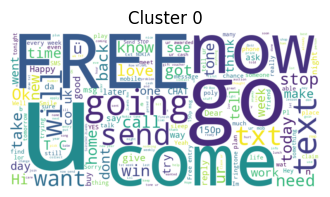

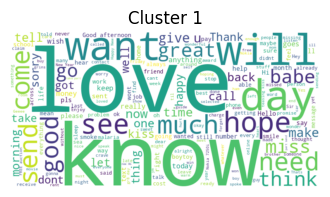

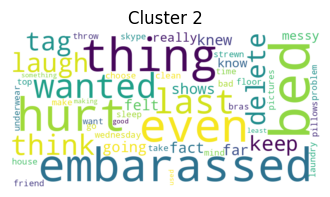

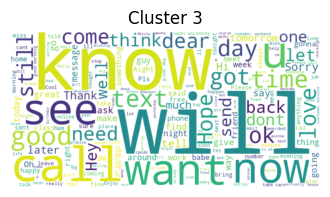

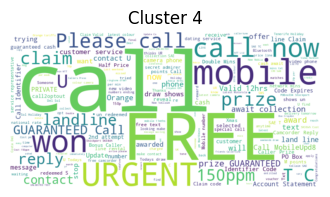

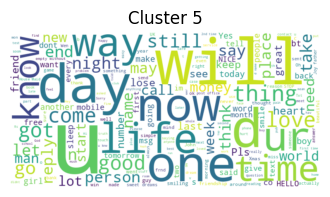

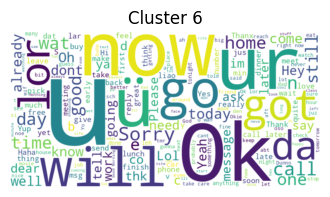

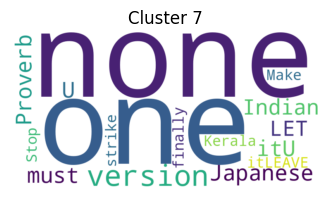

In [ ]:
# Wordcloud of most common/important words from each cluster
num_clusters = km_opt.n_clusters

for cluster_id in range(num_clusters):
    cluster_words = " ".join(df[df["cluster_opt"] == cluster_id]["msg"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cluster_words)

    plt.figure(figsize=(4, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_id}")
    plt.show()

In [ ]:
# Outlier Messages
# Identify clusters with mostly spam and mostly non-spam messages
mostly_spam_clusters = cluster_analysis[cluster_analysis["Spam Percentage"] > 80].index.tolist()
mostly_nonspam_clusters = cluster_analysis[cluster_analysis["Spam Percentage"] < 20].index.tolist()

print("Clusters with mostly spam messages:")
print(mostly_spam_clusters)

print("Clusters with mostly non-spam messages:")
print(mostly_nonspam_clusters)

# Find spam messages in mostly non-spam clusters
spam_in_non_spam = df[(df["cluster_opt"].isin(mostly_nonspam_clusters)) & (df["type"] == 1)]

# Find non-spam messages in mostly spam clusters
non_spam_in_spam = df[(df["cluster_opt"].isin(mostly_spam_clusters)) & (df["type"] == 0)]

print("\nSpam messages in a mostly non-spam cluster:")
print("\n".join(spam_in_non_spam.sample(min(3, len(spam_in_non_spam)))["msg"].to_list()))  # Avoid empty sample error

print("\nNon-spam messages in a mostly spam cluster:")
print("\n".join(non_spam_in_spam.sample(min(3, len(non_spam_in_spam)))["msg"].to_list()))  # Avoid empty sample error

Clusters with mostly spam messages:
[4]
Clusters with mostly non-spam messages:
[1, 2, 3, 5, 6, 7]

Spam messages in a mostly non-spam cluster:
Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner
Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
You will be receiving this week's Triple Echo ringtone shortly. Enjoy it!

Non-spam messages in a mostly spam cluster:
We are pleased to inform that your application for Airtel Broadband is processed successfully. Your installation will happen within 3 days.
As per your request 'Maangalyam (Alaipayuthe)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
Waiting for your call.


In [ ]:
# Cluster classification for new messages

new_messages = [
    "Hey, are we still on for the meeting tomorrow?",
    "Congratulations, you have won a free vacation! Call now to claim your prize.",
    "Limited time offer: 50% off on all products! Visit our website now.",
    "Reminder: Your doctor's appointment is scheduled for 3 PM today."
]

new_X = vectorizer.transform(new_messages)

new_clusters = km_opt.predict(new_X)

distances = np.linalg.norm(new_X.toarray()[:, np.newaxis] - km_opt.cluster_centers_, axis=2)

closest_clusters = np.argmin(distances, axis=1)

for idx, msg in enumerate(new_messages):
    print(f"Message: {msg}")
    print(f"Predicted Cluster: {new_clusters[idx]}")
    print(f"Closest Cluster: {closest_clusters[idx]}")
    print(f"Distance to Cluster Centers: {distances[idx]}\n")

Message: Hey, are we still on for the meeting tomorrow?
Predicted Cluster: 6
Closest Cluster: 6
Distance to Cluster Centers: [ 3.20219646  4.46146075 24.10394159  3.10565428  3.2629574   3.02343756
  2.91996939 17.80449381]

Message: Congratulations, you have won a free vacation! Call now to claim your prize.
Predicted Cluster: 4
Closest Cluster: 4
Distance to Cluster Centers: [ 3.09635197  3.87680694 23.68543856  3.04544219  2.49964844  3.67380522
  3.28230144 17.8605711 ]

Message: Limited time offer: 50% off on all products! Visit our website now.
Predicted Cluster: 6
Closest Cluster: 6
Distance to Cluster Centers: [ 3.70144082  5.06124199 24.49489743  3.66768256  3.73871262  3.95880064
  3.42925788 17.88854382]

Message: Reminder: Your doctor's appointment is scheduled for 3 PM today.
Predicted Cluster: 6
Closest Cluster: 6
Distance to Cluster Centers: [ 3.10626531  4.53308535 24.57641145  3.03836718  3.02661601  3.25496281
  2.78289518 17.77638883]



# PCA

In [37]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [49]:
# 3D Scatter Plot
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['id'] = df.index

pca_df['cluster'] = df['cluster']

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', hover_data=['id'], color=pca_df['cluster'].astype(str))
fig.show()

# 0 - Ham and 1 - Spam

In [ ]:
# Based on interacting with the scatter plot, I found the two points (1038 & 1780) to be the farthest away
row_index1 = pca_df[pca_df['id'] == 1038].index[0]
message1 = df.loc[row_index1, 'msg']
print("Message from point 1038:")
print(message1)

row_index2 = pca_df[pca_df['id'] == 1780].index[0]
message2 = df.loc[row_index2, 'msg']
print("\nMessage from point 1780:")
print(message2)

Message from point 1038:
For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..

Message from point 1780:
The last thing i ever wanted to do was

Total number of features: 8341
Optimal number of components for 50% variance: 685


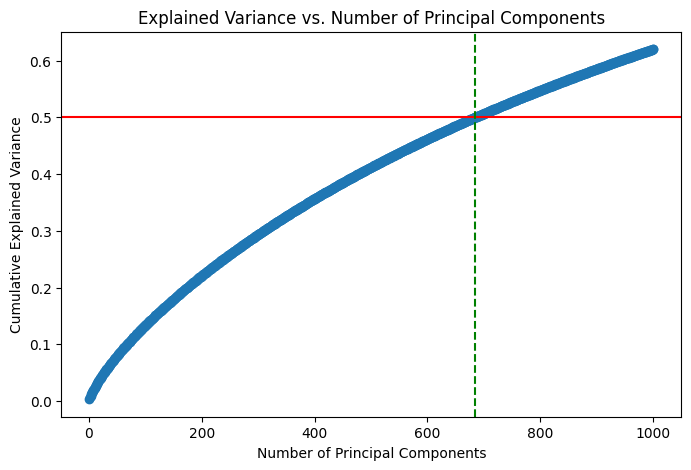

In [ ]:
# Features in the Dataset, Variance, and Graph showing such
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1000)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

num_features = X.shape[1]
print(f"Total number of features: {num_features}")

optimal_k = np.argmax(cumulative_variance > 0.50) + 1
print(f"Optimal number of components for 50% variance: {optimal_k}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.50, color='r', linestyle='-')
plt.axvline(x=optimal_k, color='g', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [ ]:
# 2D Image of the PCA
fig = px.scatter(pca_df, x="PC1", y="PC2", color = pca_df["cluster"].astype(str))
fig.show()

# Dimensionality Reduction and Classification

In [ ]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Using 1NN Classifier with fully vectorized features (runtime, accuracy, f1-score)
start_time_full = time.time()

knn_full = KNeighborsClassifier(n_neighbors=1)

knn_full.fit(X_train, y_train)

y_pred_full = knn_full.predict(X_test)

accuracy_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)

end_time_full = time.time()
runtime_full = end_time_full - start_time_full

print("Full Feature-based 1-NN Classifier:")
print(f"Accuracy: {accuracy_full}")
print(f"F1-Score: {f1_full}")
print(f"Runtime: {runtime_full:.4f} seconds")

Full Feature-based 1-NN Classifier:
Accuracy: 0.9519321394910462
F1-Score: 0.7883817427385892
Runtime: 0.2017 seconds


In [50]:
# Using 1NN Classifier with dimensionality reduction features (runtime, accuracy, f1-score)
start_time_pca = time.time()

pca = PCA(n_components=685) # Determined in PCA Section

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier(n_neighbors=1)

knn_pca.fit(X_train_pca, y_train)

y_pred_pca = knn_pca.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

end_time_pca = time.time()
runtime_pca = end_time_pca - start_time_pca

print("PCA-based 1-NN Classifier:")
print(f"Accuracy: {accuracy_pca}")
print(f"F1-Score: {f1_pca}")
print(f"Runtime: {runtime_pca:.4f} seconds")

PCA-based 1-NN Classifier:
Accuracy: 0.9500471253534402
F1-Score: 0.7854251012145749
Runtime: 29.0784 seconds


In [ ]:
print("Comparison of Classifiers:")
print(f"Full Feature-based 1-NN Classifier\nAccuracy: {accuracy_full}\nF1-Score: {f1_full}\nRuntime: {runtime_full:.4f} seconds")
print(f"\nPCA-based 1-NN Classifier\nAccuracy: {accuracy_pca}\nF1-Score: {f1_pca}\nRuntime: {runtime_pca:.4f} seconds")

Comparison of Classifiers:
Full Feature-based 1-NN Classifier
Accuracy: 0.9519321394910462
F1-Score: 0.7883817427385892
Runtime: 0.2017 seconds

PCA-based 1-NN Classifier
Accuracy: 0.9500471253534402
F1-Score: 0.7854251012145749
Runtime: 31.2490 seconds


# Spam Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pca = PCA(n_components=639)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# Find the optimal k
k_values = range(1, 21)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)

best_k = k_values[np.argmax(accuracy_scores)]
print(f"Optimal k: {best_k}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='b', label='Accuracy')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Finding the Optimal k for KNN")
plt.legend()
plt.show()

Final Accuracy with best k=1: 0.9500471253534402
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       915
           1       0.96      0.66      0.79       146

    accuracy                           0.95      1061
   macro avg       0.95      0.83      0.88      1061
weighted avg       0.95      0.95      0.95      1061



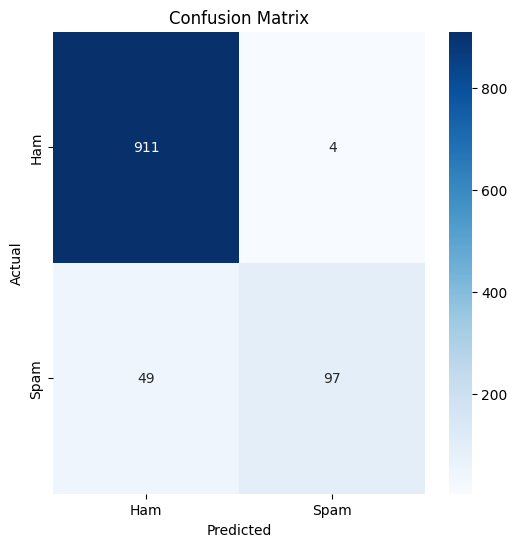

In [35]:
# Train KNN with the optimal k
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train_pca, y_train)

y_pred = knn_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Final Accuracy with best k={best_k}: {accuracy}")
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()